In [ ]:
#mkdir /content/tmp
#%cp -r -f -v /content/drive/MyDrive/SUMONBDT /content/tmp
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/SUMONBDT
#%cd /home/liuli/github/SUMONBDT
#!nvidia-smi
#用于测试oneHot
#############################################################也是第一步，读取数据
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



enc = OneHotEncoder()
#[2,3,5,9]
x1 = [0,0,0,0]
x2 = [0,0,0,1]

x3 = [1,1,1,2]
x4 = [1,1,1,3]
x5 = [1,1,2,4]
x6 = [1,1,2,5]
x7 = [1,2,3,6]
x8 = [1,2,3,7]
x9 = [1,2,4,8]
X = [x1, x2, x3,x4,x5,x6,x7,x8,x9]
enc.fit(X)
#print(enc.transform(X).toarray())


########################读写CSV,并转为oneHot
file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)

x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y = enc.transform(y).toarray()

print("x.shape:",x.shape,"yOneHot.shape:",y.shape)



del xyDataTmp #节省内存
del xyData #节省内存



In [ ]:

################################################################第二步，训练
#1. 核心为keras220不是pytorch
#2. 基于hmcnf
import model_hmcnf
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

#os.environ["CUDA_VISIBLE_DEVICES"]="0"

#hierarchy = [18, 80, 178, 142, 77, 4]
hierarchy = [2,3,5,9]
features_size = x.shape[1]
label_size = y.shape[1]
beta = 0.2
dropout_rate=0.1
relu_size=384



def local_model(num_labels, dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_labels, activation='sigmoid'))
    return model


def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model


def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

features = layers.Input(shape=(features_size,))
global_models = []
local_models = []


for i in range(len(hierarchy)):
    if i == 0:
        global_models.append(global_model(dropout_rate, relu_size)(features))
    else:
        global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

p_glob = sigmoid_model(label_size)(global_models[-1])


#显示只有全局模型的情况
#modelTmp1 = tf.keras.Model(inputs=[features], outputs=[p_glob])
#modelTmp1.summary()#
#plot_model(modelTmp1, to_file='Flatten1.png', show_shapes=True)


for i in range(len(hierarchy)):
    local_models.append(local_model(hierarchy[i], dropout_rate, relu_size)(global_models[i]))
    
#显示只有局部局模型的情况(部分全局)
p_loc = layers.concatenate(local_models)
#modelTmp2 = tf.keras.Model(inputs=[features], outputs=[p_loc])
#modelTmp2.summary()#
#plot_model(modelTmp2, to_file='Flatten2.png', show_shapes=True)
p_glob1 = layers.Lambda(lambda x: x*beta,name="global")(p_glob)
p_loc1 = layers.Lambda(lambda x: x*(1-beta),name="local")(p_loc)

labels = layers.add([p_glob1, p_loc1])

model = tf.keras.Model(inputs=[features], outputs=[labels])




plot_model(model, to_file='FlattenAll.png', show_shapes=True)


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['mae'])
model.fit([x],[y],epochs=1000, batch_size=25600*1)
model.save("hmcnf10000.h5")

In [ ]:
##################################################################第三步，验证
#%cd /content/drive/MyDrive/SUMONBDT
import model_hmcnf
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import numpy as np
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#######################0.准备onehot
enc = OneHotEncoder()
#[2,3,5,9]
x1 = [0,0,0,0]
x2 = [0,0,0,1]

x3 = [1,1,1,2]
x4 = [1,1,1,3]
x5 = [1,1,2,4]
x6 = [1,1,2,5]
x7 = [1,2,3,6]
x8 = [1,2,3,7]
x9 = [1,2,4,8]
X = [x1, x2, x3,x4,x5,x6,x7,x8,x9]
enc.fit(X)

#######################2.准备数据
        
file1 = "./trainData/dataAllSim10000.csv"
file1 = "./trainData/dataAllSim.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)

x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y = enc.transform(y).toarray()


del xyDataTmp #节省内存
del xyData #节省内存
#######################3.预测模型
print("3.HMCNF预测模型")
hierarchy = [2,3,5,9]
features_size = x.shape[1]
label_size = y.shape[1]
beta = 0.2

model_name ="hmcnf.h5" 

model = keras.models.load_model(model_name)
y_out = model.predict([x], batch_size=2560)
y_predict = np.where(y_out > 0.5, 1, 0)

predict_ok = np.where(np.sum(y_predict - y, axis=1) == 0, 1, 0)


print("validated {} , {} good out of {} samples".format(model_name, np.sum(predict_ok), predict_ok.shape[0]))
del y_predict #节省内存
del predict_ok #节省内存
#######################3.层次预测预测模型
print("3.层次预测预测模型")
y1 = np.where(y_out[:,0:2] > 0.5, 1, 0)
y2 = np.where(y_out[:,2:5] > 0.5, 1, 0)
y3 = np.where(y_out[:,5:10] > 0.5, 1, 0)
y4 = np.where(y_out[:,10:19] > 0.5, 1, 0)
for i in range(y4.shape[0]):
    tmp1 = y1[i]
    tmp2 = y2[i]
    tmp3 = y3[i]
    tmp4 = y4[i]
    if sum(tmp1) == 0:
        index=  np.argmax(tmp1)
        y1[i,index]=1
        
    if sum(tmp2) == 0:
        index=  np.argmax(tmp2)
        y2[i,index]=1
        
    if sum(tmp3) == 0:
        index=  np.argmax(tmp3)
        y3[i,index]=1
    
    if sum(tmp4) == 0:
        index=  np.argmax(tmp4)
        y4[i,index]=1
        #print(i,y4[i],index)
y_predict = np.concatenate([y1,y2,y3,y4],axis=1)
predict_ok = np.where(np.sum(y_predict - y, axis=1) == 0, 1, 0)
print("validated {} , {} good out of {} samples".format(model_name, np.sum(predict_ok), predict_ok.shape[0]))

#onehot 2 label
ypredict = enc.inverse_transform(y_predict)
del y_predict #节省内存
del predict_ok #节省内存
del y1,y2,y3,y4
#######################4.评估层次模型
#hierarchy = [2,3,5,9]

##第一层，2
print("###################################第一层，2")
h1_yp = ypredict[:,0]
h1_yl = ylabel[:,0]
tmp1 = classification_report(h1_yl,h1_yp)
tmp2 = confusion_matrix(h1_yl,h1_yp,normalize='true')
tmp3 = confusion_matrix(h1_yl,h1_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))


##第二层，3
print("################################第二层，3")
h2_yp = ypredict[:,1]
h2_yl = ylabel[:,1]
tmp1 = classification_report(h2_yl,h2_yp)
tmp2 = confusion_matrix(h2_yl,h2_yp,normalize='true')
tmp3 = confusion_matrix(h2_yl,h2_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))



##第三层，5
print("#############################第三层，5")
h3_yp = ypredict[:,2]
h3_yl = ylabel[:,2]
tmp1 = classification_report(h3_yl,h3_yp)
tmp2 = confusion_matrix(h3_yl,h3_yp,normalize='true')
tmp3 = confusion_matrix(h3_yl,h3_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))


##第四层，9
print("#############################第四层，9")
h4_yp = ypredict[:,3]
h4_yl = ylabel[:,3]
tmp1 = classification_report(h4_yl,h4_yp)
tmp2 = confusion_matrix(h4_yl,h4_yp,normalize='true')
tmp3 = confusion_matrix(h4_yl,h4_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))



In [ ]:
#第四步，根据混淆矩阵进行聚类。第一列代表识别为类别1的样本真实的类别分布
import numpy as np
import copy
#########################################手动准备模拟数据
mat1 = np.array([[0.952,0.004,0.015,0.008],
 [0.018,0.923,0.016,0.032],
 [0.016,0.036,0.934,0.047],
 [0.014,0.037,0.035,0.913]])
accy = [mat1[0,0],mat1[1,1],mat1[2,2],mat1[3,3]]
print("accuracy",accy)
matT1 = mat1
mat1[:,0] = matT1[:,0]*1000
mat1[:,1] = matT1[:,1]*1000
mat1[:,2] = matT1[:,2]*1000
mat1[:,3] = matT1[:,3]*1000
sumTmp =  sum(mat1)
print(sumTmp)
print(mat1)

##########################################计算最佳合并位置，根据最大的正确率提高
def computeAccuracyDiff(mat1,accy):
    h,w = mat1.shape
    tmp = np.zeros((h-1,w-1))
    matTmp={}
    ##从0到最后，行列合并
    for index in range(h-1):

        tmp = np.zeros((h-1,w))
        num = 0
        ####行合并
        for i in range(h):#行合并
            if i == index:
                tmp[num]=mat1[i]+mat1[i+1]
                num=num+1
                continue
            if i== index+1:
                continue

            tmp[num]=mat1[i]
            num=num+1

        ####列合并   
        mat2=tmp
        tmp = np.zeros((h-1,w-1))
        num = 0
        for j in range(w):#列合并
            if j == index:
                tmp[:,num] = mat2[:,j]+mat2[:,j+1]
                num=num+1
                continue
            if j== index+1:
                continue

            tmp[:,num] = mat2[:,j]
            num=num+1
        matTmp[index] = tmp
        
        #print("合并后的所有矩阵")
        #print(index,matTmp[index])#合并后的所有矩阵
    matTmp1 = copy.deepcopy(matTmp)
   
    ##归一化   
    maxDiffMat = np.zeros((len(matTmp),1))
    for i in range(len(matTmp)):
        tmp = matTmp[i]
        sumTmp =  sum(tmp)
        for j in range(tmp.shape[1]):
            tmp[:,j] = tmp[:,j]/(sumTmp[j])

        accyNow = tmp[i,i]
        maxDiffMat[i]= max(accyNow-accy[i],accyNow-accy[i+1])
    maxIndex = np.argmax(maxDiffMat)
    maxDiff = max(maxDiffMat)
    #print(matTmp1)
    return maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1

#为了思考，不用for循环，直接一步一步做
#4到3
maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])

#3到2
mat3to2=matTmp1[maxIndex]
accy3to2 = [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2]]
maxIndex3to2,maxDiff3to2,maxDiffMat3to2,matTmp3to2,matTmp3to2Origin =computeAccuracyDiff(mat3to2,accy3to2)
chosedMat = matTmp3to2Origin[maxIndex3to2]
print("最佳合并点和矩阵",maxIndex3to2,maxDiff3to2)
print(matTmp3to2Origin[maxIndex3to2])
print(matTmp3to2[maxIndex3to2])


#########################################采用数据进行分析
print("\n\n\n###################################################")
print("\n\n\n 用第5层数据进行分析")
h3_yp = ypredict[:,2]
h3_yl = ylabel[:,2]
mat1 = confusion_matrix(h3_yl,h3_yp)
p1 = confusion_matrix(h3_yl,h3_yp,normalize='pred')
sumTmp = sum(mat1)
print(mat1)
print(sumTmp)
print(np.around(p1, decimals=3))

########5->4
accy = [p1[0,0],p1[1,1],p1[2,2],p1[3,3],p1[4,4]]
maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n5->4,最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])
print(np.around(matTmp[maxIndex], decimals=3))

########4->3
mat1=matTmp1[maxIndex]
accy= [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2],matTmp[maxIndex][3,3]]

maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n4->3,最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])
print(np.around(matTmp[maxIndex], decimals=3))


########3->2
mat1=matTmp1[maxIndex]
accy= [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2]]

maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n3->2,最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])
print(np.around(matTmp[maxIndex], decimals=3))

In [ ]:
##测试最简注意力机制，Attention Channel ,SEAttention
import pandas as pd
import numpy as np
from keras.utils.vis_utils import plot_model
np.random.seed(1337)  # for reproducibility
 
from keras.models import *
from keras.layers import Input, Dense,Multiply,Activation
 
input_dim = 4


def get_data(n, input_dim, attention_column=1):

    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

 
 
def Att(att_dim,inputs,name):
    V = inputs
    QK = Dense(att_dim,bias=None)(inputs)
    QK = Activation("softmax",name=name)(QK)
    MV = Multiply()([V, QK])
    return(MV)
 
 
def build_model():
    inputs = Input(shape=(input_dim,))
 
    atts1 = Att(input_dim,inputs,"attention_vec")
 
    x = Dense(16)(atts1)
    atts2 = Att(16,x,"attention_vec1")
 
 
    output = Dense(1, activation='sigmoid')(atts2)
    model = Model(input=inputs, output=output)
    return model

N = 10000
inputs_1, outputs = get_data(N, input_dim) 
print(inputs_1)
 
m = build_model()
plot_model(m, to_file='attMap.png', show_shapes=True)
#m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#print(m.summary())
#m.fit(inputs_1, outputs, epochs=20, batch_size=128, validation_split=0.2)testing_inputs_1, testing_outputs = get_data(1, input_dim)


#原文链接：https://blog.csdn.net/xiaosongshine/article/details/90579679

In [ ]:
#https://blog.csdn.net/SKIp121whats112/article/details/122265766
#https://scikit-learn.org/stable/modules/tree.html
##############测试决策树
from sklearn import tree
import graphviz 
Input= x
Output = ylabel[:,2]
print(x)
print(Output)
dt = tree.DecisionTreeClassifier(max_depth=5,min_samples_split=100,min_samples_leaf=100,min_impurity_decrease=0.001)
dt = dt.fit(Input, Output)
tree.plot_tree(dt)
data=tree.export_graphviz(dt, out_file=None,class_names=['0','1','2','3','4'],filled=True) 
graph = graphviz.Source(data)
graph.render("now")

data=tree.export_graphviz(dt, out_file=None,class_names=['0','1','2','3','4'],filled=True,proportion=True) 
graph = graphviz.Source(data)
graph.render("nowPercent")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
OutPredict = dt.predict(Input)

tmp1 = classification_report(Output,OutPredict )
tmp2 = confusion_matrix(Output,OutPredict ,normalize='true')
tmp3 = confusion_matrix(Output,OutPredict ,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))

In [ ]:
#测试决策树的特征
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
###测试权重
nSamples =5000
input_dim = 10
#x = np.random.standard_normal(size=(nSamples, input_dim))
x = np.random.randint(low=0, high=10, size=(nSamples, input_dim))
y1 = np.zeros((nSamples, 1))#>50
y1A = np.zeros((nSamples, 1))#>50 and <60
y1B = np.zeros((nSamples, 1))#>=60
sumX = np.sum(x,axis=1)
index=np.where(sumX>40)
y1[index]=1
index=np.where((sumX>50)& (sumX<70))
y1A[index]=1
index=np.where(sumX>=70)
y1B[index]=1

##数据来源2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
xyData = np.array(xyDataTmp)
nSamples, nDims= xyData.shape
x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y1= y[:,0]


##################################################################
#测试决策树
def dtFitAndSave(x,y,class_names1,saveName):
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_split=100,min_samples_leaf=100,min_impurity_split=0.06,ccp_alpha=0.001)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    data=tree.export_graphviz(dt, out_file=None,class_names=class_names1,filled=True) 
    graph = graphviz.Source(data)
    graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print(tmp1)
    text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    
    yPredict = dt.predict_proba(x[0:3,:])
    print(yPredict[:,1])
    d_path = dt.decision_path(x[0:3,:]).todense()
    print(d_path)
    print("impurity",dt.tree_.impurity)
    print("feature",dt.tree_.feature)
    print("threshold",dt.tree_.threshold)
    
    #左节点编号  :  clf.tree_.children_left
    #右节点编号  :  clf.tree_.children_right
    #分割的变量  :  clf.tree_.feature
    #分割的阈值  :  clf.tree_.threshold
    #不纯度(gini) :  clf.tree_.impurity
    #样本个数      :  clf.tree_.n_node_samples
    #样本分布      :  clf.tree_.value
    #https://blog.csdn.net/ywj_1991/article/details/122985778
    #https://www.javaroad.cn/questions/54003

    w,h = d_path.shape
    for i in range(h):
       path = d_path[i]
       v,ind = np.where(path>0)
       xtmp = x[i]
       #print("path",path,ind,np.array(ind)[-1])
    
       print("\n index",index)
       print("impurity",dt.tree_.impurity[ind])
       print("feature",dt.tree_.feature[ind])
       print("threshold",dt.tree_.threshold[ind])
       print("x[index]",xtmp[ind])
       
      
       print("the leaf node:",np.array(ind)[-1],"the simplest rule is")
       for jj in ind:
           if dt.tree_.feature[jj] == -2:
                print("label,proba is",yPredict[i,0],yPredict[i,1])
                break
                
           if xtmp[jj]<=dt.tree_.threshold[jj]:
              print(" x[%d]<=%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
           else:
              print(" x[%d]>%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
                    
       finalPos = np.array(ind)[-1]
       print(dt.tree_.impurity[finalPos])
       print(dt.tree_.feature[finalPos])
       print(dt.tree_.threshold[finalPos])

dtFitAndSave(x,y1,["0","1"],"bigger")

###################################################################################
#测试神经网络
def kerasFitAndSave(x,y,num_labels):
    nSamples,features_size = x.shape
    relu_size = 384
    dropout_rate =0.1
    models=[]
    
    build_model = tf.keras.Sequential()
   
    build_model.add(layers.Dense(relu_size, activation='relu',name="layer1",input_shape=(features_size,)))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout1-2"))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer2"))
    
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    plot_model(build_model, to_file='AKeras.png', show_shapes=True)
    
    enc = OneHotEncoder()
    enc.fit(y)  
    yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOnehot],epochs=100, batch_size=80000*1)
    build_model.save("Akeras.h5")
    plot_model(build_model, to_file='AKeras.png', show_shapes=True)
    
    return build_model,models

def kerasFitAndSaveSimple(x,y,num_labels):
    nSamples,features_size = x.shape
    relu_size = 382
    models=[]
    
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(relu_size, activation='relu'))
    build_model.add(layers.Dropout(dropout_rate))
    build_model.add(layers.Dense(num_labels, activation='sigmoid'))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer1",input_shape=(features_size,)))
    
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    plot_model(build_model, to_file='AKerasSimple.png', show_shapes=True)
    
    enc = OneHotEncoder()
    enc.fit(y)  
    yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOnehot],epochs=10000, batch_size=80000*1)
    build_model.save("Akeras.h5")
    plot_model(build_model, to_file='AKeras.png', show_shapes=True)
    
    return build_model,models

y1 = np.array(y1)
y1= y1.reshape(nSamples,-1)
print(y1)
#kerasFitAndSave(x,y1,2)
#kerasFitAndSaveSimple(x,y1,2)

In [ ]:
########################################融合决策树和多层神经网络###########################################################

#######################################第一步读取数据
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
xyData = np.array(xyDataTmp)
nSamples, nDims= xyData.shape
x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y1Level= y[:,0]#01
y2Level= y[:,1]#012
y3Level= y[:,2]#01234

print("x.shape:",x.shape,"y.shape:",y.shape)

del xyDataTmp #节省内存
del xyData #节省内存

In [ ]:
########################################融合决策树和多层神经网络###########################################################

#######################################第二步基于神经网络训练，这里采用简单神经网络，RESNET类似和HNCF三种方法进行训练
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
###简单模型1，没有隐藏层
def kerasFitAndSaveSimple1(x,yOneHot,num_labels):
    nSamples,features_size = x.shape
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer1",input_shape=(features_size,)))
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOneHot],epochs=10000, batch_size=80000*1)
    build_model.save("kerasSimple1.h5")
    plot_model(build_model, to_file='KerasSimple1_noHiddenLayer.png', show_shapes=True)
    return build_model

###简单模型2，有隐藏层
def kerasFitAndSaveSimple2(x,yOneHot,num_labels):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(relu_size, activation='relu',name="layer1",input_shape=(features_size,)))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout1-2"))
    build_model.add(layers.Dense(relu_size/2, activation='relu',name="layer2"))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout2-3"))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer3"))
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOneHot],epochs=10000, batch_size=80000*1)
    build_model.save("kerasSimple2.h5")
    plot_model(build_model, to_file='KerasSimple2_HiddenLayer.png', show_shapes=True)
    return build_model

###简单模型3，resnet_like
def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]
    global_models = []
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOneHot],epochs=10000, batch_size=80000*1)
    build_model.save("KerasSimple3_likeResnet.h5")
    plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model
    print("HMCNF is not implemented")
    return False

nSamples,features_size = x.shape
num_labels = 5
enc = OneHotEncoder()
y3Level = np.array(y3Level)
y3Level= y3Level.reshape(nSamples,-1)
print(y3Level)
enc.fit(y3Level)  

###开始训练
x_train, x_test, y_train, y_test = train_test_split(x, y3Level, test_size = 0.5)


x = x_train
yOneHot=enc.transform(y_train).toarray()
print(yOneHot)
#simpleMode1 = kerasFitAndSaveSimple1(x,yOneHot,num_labels)
simpleMode2 = kerasFitAndSaveSimple2(x,yOneHot,num_labels)
#simpleMode3 = kerasFitAndSaveSimple3(x,yOneHot,num_labels)

In [ ]:
########################################融合决策树和多层神经网络###########################################################
#######################################第三步根据识别结果，进行聚类聚类
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy

####################################################################
file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
print("x.shape:",x.shape,"y.shape:",y.shape)



del xyDataTmp #节省内存
del xyData #节省内存
#################################################################

if 0:#采用keras
    model_name ="kerasSimple2.h5" 
    model = keras.models.load_model(model_name)
    yP5= model.predict([x], batch_size=2560)

    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(yP5.shape[0]):
        tmp = yP5[i]
        index=  np.argmax(tmp)
        yP5[i] = [0,0,0,0,0]
        yP5[i,index]=1
    print(yP5)

    ###
    enc = OneHotEncoder()
    yl5= y[:,2]#01234
    yl5 = np.array(yl5)
    yl5= yl5.reshape(nSamples,-1)
    print(yl5)
    enc.fit(yl5)

    yP5= enc.inverse_transform(yP5)
    yP5= yP5.reshape(-1,nSamples)[0]
    ########



    print(yP5)
    print(yP5.shape)

    print(yl5)
    print(yl5.shape)

if 1:#采用决策树
    yl5= y[:,2]#01234
    dt = tree.DecisionTreeClassifier(max_depth=10,min_samples_leaf=100)
    dt = dt.fit(x, yl5)
    yPredict = dt.predict(x)
    tmp1 = classification_report(yl5,yPredict)
    print(tmp1)
    mat1num = confusion_matrix(yl5,yPredict)
    mat2acc = confusion_matrix(yl5,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    yP5 = yPredict

###################################开始合并
hierachFloor = dict()
hierachFloor ['input'] = x
hierachFloor ['output'] = y

                               
                                    
                                    
#0层为原始输入层
mat1num = confusion_matrix(yl5 ,yP5)
mat2acc = confusion_matrix(yl5,yP5,normalize='pred')
print(mat1num)
print(np.around(mat2acc , decimals=3))
hierachFloor ['floor0'] = {'label':['0','1','2','3','4'],'num_mat': mat1num,'prob_mat': mat2acc}
                                    

def computeAccuracyDiff(mat1,accy):
    h,w = mat1.shape
    tmp = np.zeros((h-1,w-1))
    matTmp={}
    ##从0到最后，行列合并
    for index in range(h-1):

        tmp = np.zeros((h-1,w))
        num = 0
        ####行合并
        for i in range(h):#行合并
            if i == index:
                tmp[num]=mat1[i]+mat1[i+1]
                num=num+1
                continue
            if i== index+1:
                continue

            tmp[num]=mat1[i]
            num=num+1

        ####列合并   
        mat2=tmp
        tmp = np.zeros((h-1,w-1))
        num = 0
        for j in range(w):#列合并
            if j == index:
                tmp[:,num] = mat2[:,j]+mat2[:,j+1]
                num=num+1
                continue
            if j== index+1:
                continue

            tmp[:,num] = mat2[:,j]
            num=num+1
        matTmp[index] = tmp
        
        #print("合并后的所有矩阵")
        #print(index,matTmp[index])#合并后的所有矩阵
    matTmp1 = copy.deepcopy(matTmp)
   
    ##归一化   
    maxDiffMat = np.zeros((len(matTmp),1))
    for i in range(len(matTmp)):
        tmp = matTmp[i]
        sumTmp =  sum(tmp)
        for j in range(tmp.shape[1]):
            tmp[:,j] = tmp[:,j]/(sumTmp[j])

        accyNow = tmp[i,i]
        maxDiffMat[i]= max(accyNow-accy[i],accyNow-accy[i+1])
    maxIndex = np.argmax(maxDiffMat)
    maxDiff = max(maxDiffMat)
    #print(matTmp1)
    return maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1
#print("最佳合并点和矩阵",maxIndex,maxDiff)
#print(“所有合并后的所有矩阵，数目和概率",matTmp,matTmp1)
#print(“各个点合并后的正确率提升矩阵",maxDiffMat)

print("\n\n\n###################################################")
print("\n\n\n 用数据进行分析")

#1层为5到4层
accy = [mat2acc[0,0],mat2acc[1,1],mat2acc[2,2],mat2acc[3,3],mat2acc[4,4]]
maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1num,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n5->4,最佳合并点和矩阵",maxIndex,maxDiff)
print(maxDiffMat)
print("数目矩阵\n",matTmp1[maxIndex])
print("概率矩阵\n",np.around(matTmp[maxIndex], decimals=3))
hierachFloor ['floor1'] = {'num_mat': matTmp1,'prob_mat': matTmp,'mergeIndex':maxIndex,'mergediffMat':maxDiffMat}

###2层4->3
mat1num=matTmp1[maxIndex]
mat2acc= [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2],matTmp[maxIndex][3,3]]

maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1num,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n4->3,最佳合并点和矩阵",maxIndex,maxDiff)
print(maxDiffMat)
print("数目矩阵\n",matTmp1[maxIndex])
print("概率矩阵\n",np.around(matTmp[maxIndex], decimals=3))
      
hierachFloor ['floor2'] = {'num_mat': matTmp1,'prob_mat': matTmp,'mergeIndex':maxIndex,'mergediffMat':maxDiffMat}
 
###3层3->2
mat1num=matTmp1[maxIndex]
mat2acc= [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2]]

maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1num,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n3->2,最佳合并点和矩阵",maxIndex,maxDiff)
print(maxDiffMat)
print("数目矩阵\n",matTmp1[maxIndex])
print("概率矩阵\n",np.around(matTmp[maxIndex], decimals=3))
      
hierachFloor['floor3'] = {'num_mat': matTmp1,'prob_mat': matTmp,'mergeIndex':maxIndex,'mergediffMat':maxDiffMat}

In [ ]:
########################################融合决策树和多层神经网络###########################################################
#######################################第四步根据聚类和识别结果，开始微调

import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy


##################
file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)

x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
print("x.shape:",x.shape,"y.shape:",y.shape)

yl5= y[:,2]#01234
print("x.shape:",x.shape,"yl5.shape:",yl5.shape)
del xyDataTmp #节省内存
del xyData #节省内存

print("x.shape:",x.shape,"y.shape:",yl5.shape,"y.type:", type(yl5) )





##################################################################
##################################################################


def getKerasModeFloors(x,y,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    yP5= model.predict([x], batch_size=2560)
    nSamples = yP5.shape[0]
     ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(yP5.shape[0]):
        tmp = yP5[i]
        index=  np.argmax(tmp)
        yP5[i] = [0,0,0,0,0]
        yP5[i,index]=1
   

    ###
    enc = OneHotEncoder()
    yl5= y[:,2]#01234
    yl5 = np.array(yl5)
    yl5= yl5.reshape(nSamples,-1)
    print(yl5)
    enc.fit(yl5)

    yP5= enc.inverse_transform(yP5)
    yP5= yP5.reshape(-1,nSamples)[0]
    
    yP4 = np.zeros((yP5.shape[0],1))
    yP3 = np.zeros((yP5.shape[0],1))
    yP2 = np.zeros((yP5.shape[0],1))

    for i in range(yP5.shape[0]):
        if(yP5[i]== 2) or (yP5[i]== 1):
             yP4[i] = 21
        else:
             yP4[i] = yP5[i]
                
        if(yP5[i]== 2) or (yP5[i]== 1) or (yP5[i]== 0):
             yP3[i] = 210
        else:
             yP3[i] = yP5[i]
                
        if(yP5[i]== 2) or (yP5[i]== 1) or (yP5[i]== 0) or (yP5[i]== 3):
             yP2[i] = 3210
        else:
             yP2[i] = yP5[i]
    
    return model,yP5,yP4,yP3,yP2

#分层决策树
def dtFitAndSave(x,y,saveName):
    dt = tree.DecisionTreeClassifier(max_depth=10,min_samples_leaf=1000)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    graph = graphviz.Source(data)
    graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print(tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt

##########################################################################
##########################################################################
def getDTSamplesInfo(x,dt):
    yPredict = dt.predict_proba(x)
    #print("\n\n getDTSamplesInfo yPredict",yPredict)
    d_path = dt.decision_path(x).todense()
    #print("\n\n d_path",d_path)
    #print("impurity",dt.tree_.impurity)
    #print("feature",dt.tree_.feature)
    #print("threshold",dt.tree_.threshold)
    
    #左节点编号  :  clf.tree_.children_left
    #右节点编号  :  clf.tree_.children_right
    #分割的变量  :  clf.tree_.feature
    #分割的阈值  :  clf.tree_.threshold
    #不纯度(gini) :  clf.tree_.impurity
    #样本个数      :  clf.tree_.n_node_samples
    #样本分布      :  clf.tree_.value
    #https://blog.csdn.net/ywj_1991/article/details/122985778
    #https://www.javaroad.cn/questions/54003
    
    h,w = d_path.shape
    gini =np.zeros((h,1))
    
    
    
    for i in range(h):
       path = d_path[i]
       v,ind = np.where(path>0)
       xtmp = x[i]
       #print("path",path,ind,np.array(ind)[-1])
    
       #print("\n index",index)
       #print("impurity",dt.tree_.impurity[ind])
       #print("feature",dt.tree_.feature[ind])
       #print("threshold",dt.tree_.threshold[ind])
       #print("x[index]",xtmp[ind])
       
      
       #print("the leaf node:",np.array(ind)[-1],"the simplest rule is")
       #for jj in ind:
       #    if dt.tree_.feature[jj] == -2:
       #         print("label,proba is",yPredict[i,0],yPredict[i,1])
       #         break
                
       #    if xtmp[jj]<=dt.tree_.threshold[jj]:
       #       print(" x[%d]<=%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
       #    else:
       #       print(" x[%d]>%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
                    
       finalPos = np.array(ind)[-1]
       gini[i] = dt.tree_.impurity[finalPos]
       
       #print("d_path",i,path,dt.tree_.impurity[finalPos])
       #print(dt.tree_.feature[finalPos])
       #print(dt.tree_.threshold[finalPos])
       #print(dt.tree_.n_node_samples[finalPos])

    
    return gini,yPredict


##########################################################################



index = np.where((yl5 == 2) | (yl5 == 1))
yl4 = yl5.copy()
yl4[index]=21
print(yl4)


index = np.where((yl5 == 2) | (yl5 == 1) | (yl5 == 0))
yl3 = yl5.copy()
yl3[index]=210
print(yl3)



index = np.where( (yl5 == 3)|(yl5 == 2) | (yl5 == 1) | (yl5 == 0))
yl2 = yl5.copy()
yl2[index]=3210
print(yl2)

hierachFloor['floor3']["dt"] = dtFitAndSave(x,yl2,"Floo3_2")
hierachFloor['floor2']["dt"] = dtFitAndSave(x,yl3,"Floo2_3")
hierachFloor['floor1']["dt"] = dtFitAndSave(x,yl4,"Floor1_4")
hierachFloor['floor0']["dt"] = dtFitAndSave(x,yl5,"Floor0_5")

#giniFloor0,yPredictProFloor0 = getDTSamplesInfo(x,hierachFloor['floor0']["dt"])
#giniFloor1,yPredictProFloor1 = getDTSamplesInfo(x,hierachFloor['floor1']["dt"])
#giniFloor2,yPredictProFloor2 = getDTSamplesInfo(x,hierachFloor['floor2']["dt"])
#giniFloor3,yPredictProFloor3 = getDTSamplesInfo(x,hierachFloor['floor3']["dt"])

kerasFloors,yKerasP5,yKerasP4,yKerasP3,yKerasP2=getKerasModeFloors(x,y,'kerasSimple2.h5')
##############开始混合检测

###0层，5标签

'''
nSamples,feturesNume  = x.shape
yHyLabelFloor0 = np.zeros((nSamples,1))
hyCounter = 0
for i in range(nSamples):
    print(i)
    xtmp = x[i]
    dt = hierachFloor['floor0']["dt"]
    giniFloor0,yPredictProFloor0 = getDTSamplesInfo([xtmp],dt)
    giniTmp = giniFloor0[0]
    yPredictProFloor0Tmp = yPredictProFloor0[0]
    #print('gini',giniTmp )
    #print('probPredict',yPredictProFloor0Tmp  )
    if giniTmp >0.05 or max(yPredictProFloor0Tmp)<0.98:
        yHyLabelFloor0[i] = yKerasP5[i]
    else:
        yHyLabelFloor0[i] = np.argmax(yPredictProFloor0)
        hyCounter = hyCounter+1
  
print('O层5标签hyCounter',hyCounter)    


tmp1 = classification_report(yl5,yHyLabelFloor0)
print('hybrid\n',tmp1)
tmp1 = classification_report( yKerasP5,yHyLabelFloor0)
print('keras\n',tmp1)
mat1num = confusion_matrix(yl5,yHyLabelFloor0)
mat2acc = confusion_matrix(yl5,yHyLabelFloor0,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))
'''

'''
#############1层，4标签
nSamples,feturesNume  = x.shape
yHyLabelFloor1 = np.zeros((nSamples,1))
hyCounter = 0
for i in range(nSamples):
    print(i)
    xtmp = x[i]
    dt = hierachFloor['floor1']["dt"]
    giniFloor1,yPredictProFloor1 = getDTSamplesInfo([xtmp],dt)
    giniTmp = giniFloor1[0]
    yPredictProFloor1Tmp = yPredictProFloor1[0]
    #print('gini',giniTmp )
    #print('probPredict',yPredictProFloor0Tmp  )
    if giniTmp >0.05 or max(yPredictProFloor1Tmp)<0.98:
        yHyLabelFloor1[i] = yKerasP4[i]
    else:
        tmp0= [0,3,4,21]
        index = np.argmax(yPredictProFloor1)
        yHyLabelFloor1[i] = tmp0[index]
        hyCounter = hyCounter+1
print('O层4标签hyCounter',hyCounter)    


tmp1 = classification_report(yl4,yHyLabelFloor1)
print('hybrid\n',tmp1)
tmp1 = classification_report( yKerasP4,yHyLabelFloor1)
print('keras\n',tmp1)
mat1num = confusion_matrix(yl4,yHyLabelFloor1)
mat2acc = confusion_matrix(yl4,yHyLabelFloor1,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))
'''


def computeAndCompareHybridMode(x,y,dt,kerasPLabel,floorLabel):
    nSamples,feturesNume  = x.shape
    yHyLabel  = np.zeros((nSamples,1))
    hyCounter = 0
    for i in range(nSamples):
        print(i)
        xtmp = x[i]
        giniFloor,yPredictProFloor = getDTSamplesInfo([xtmp],dt)
        giniTmp = giniFloor[0]
        yPredictProFloorTmp = yPredictProFloor[0]
        #print('gini',giniTmp )
        #print('probPredict',yPredictProFloor0Tmp  )
        if giniTmp >0.05 or max(yPredictProFloorTmp)<0.98:
            yHyLabel[i] = kerasPLabel[i]
        else:
            #floorLabel= [3,4,210]
            index = np.argmax(yPredictProFloorTmp)
            yHyLabel[i] = floorLabel[index]
            hyCounter = hyCounter+1
    print('floorLabel\n',floorLabel) 
    print('hyCounter\n',hyCounter)    


    tmp1 = classification_report(y,yHyLabel)
    print('hybrid\n',tmp1)
    tmp1 = classification_report(kerasPLabel,yHyLabel)
    print('keras\n',tmp1)
    mat1num = confusion_matrix(y,yHyLabel)
    mat2acc = confusion_matrix(y,yHyLabel,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    return

#floor=2 ,label=3
#dt = hierachFloor['floor2']["dt"]
#floorLabel= [3,4,210] 
#computeAndCompareHybridMode(x,yl3,dt,yKerasP3,floorLabel)

#floor=3 ,label=2
dt = hierachFloor['floor3']["dt"]
floorLabel= [4,3210] 
computeAndCompareHybridMode(x,yl2,dt,yKerasP2,floorLabel)

return
####################################################################################################


'''
for i in range(nSamples):
    for j in range(4)
         input1 = x[i,:]
         label =  ylabel[i,j]
         output1 = Floor[j]["dt"].predict_proba(input)
         output_gini,output_num =getDT_Info(input)
    
        if max(output1)<0.95 or output_gini>0.2
            output1 =  Floor[j]["keras"].predict(input)
        
        loss=loss+(output1-label)
                           
                           
def getDT_SamplesInfo(x)
    yPredict = dt.predict_proba(x[0:3,:])
    print(yPredict[:,1])
    d_path = dt.decision_path(x[0:3,:]).todense()
    print(d_path)
    print("impurity",dt.tree_.impurity)
    print("feature",dt.tree_.feature)
    print("threshold",dt.tree_.threshold)
    
    #左节点编号  :  clf.tree_.children_left
    #右节点编号  :  clf.tree_.children_right
    #分割的变量  :  clf.tree_.feature
    #分割的阈值  :  clf.tree_.threshold
    #不纯度(gini) :  clf.tree_.impurity
    #样本个数      :  clf.tree_.n_node_samples
    #样本分布      :  clf.tree_.value
    #https://blog.csdn.net/ywj_1991/article/details/122985778
    #https://www.javaroad.cn/questions/54003

    w,h = d_path.shape
    for i in range(h):
       path = d_path[i]
       v,ind = np.where(path>0)
       xtmp = x[i]
       #print("path",path,ind,np.array(ind)[-1])
    
       print("\n index",index)
       print("impurity",dt.tree_.impurity[ind])
       print("feature",dt.tree_.feature[ind])
       print("threshold",dt.tree_.threshold[ind])
       print("x[index]",xtmp[ind])
       
      
       print("the leaf node:",np.array(ind)[-1],"the simplest rule is")
       for jj in ind:
           if dt.tree_.feature[jj] == -2:
                print("label,proba is",yPredict[i,0],yPredict[i,1])
                break
                
           if xtmp[jj]<=dt.tree_.threshold[jj]:
              print(" x[%d]<=%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
           else:
              print(" x[%d]>%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
                    
       finalPos = np.array(ind)[-1]
       print(dt.tree_.impurity[finalPos])
       print(dt.tree_.feature[finalPos])
       print(dt.tree_.threshold[finalPos])

'''

In [ ]:
#############################################################
print("建立多层独立决策树混合模型")
#############################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler



##################################################################
##################################################################


def getKerasModeFloors2(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    yP5= model.predict([x], batch_size=2560)
    nSamples = yP5.shape[0]
     ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(yP5.shape[0]):
        tmp = yP5[i]
        index=  np.argmax(tmp)
        yP5[i] = [0,0,0,0,0]
        yP5[i,index]=1
   

    ###  
    yP5= enc.inverse_transform(yP5)
    yP5= yP5.reshape(-1,nSamples)[0]
    
    yP4 = np.zeros((yP5.shape[0],1))
    yP3 = np.zeros((yP5.shape[0],1))
    yP2 = np.zeros((yP5.shape[0],1))

    for i in range(yP5.shape[0]):
        if(yP5[i]== 2) or (yP5[i]== 1):
             yP4[i] = 21
        else:
             yP4[i] = yP5[i]
                
        if(yP5[i]== 2) or (yP5[i]== 1) or (yP5[i]== 0):
             yP3[i] = 210
        else:
             yP3[i] = yP5[i]
                
        if(yP5[i]== 2) or (yP5[i]== 1) or (yP5[i]== 0) or (yP5[i]== 3):
             yP2[i] = 3210
        else:
             yP2[i] = yP5[i]
    
    return model,yP5,yP4,yP3,yP2

#分层决策树
def dtFitAndSave(x,y,saveName):
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    #tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt

##########################################################################
##########################################################################
def getDTSamplesInfo(x,dt):
    yPredict = dt.predict_proba(x)
    #print("\n\n getDTSamplesInfo yPredict",yPredict)
    d_path = dt.decision_path(x).todense()
    #print("\n\n d_path",d_path)
    #print("impurity",dt.tree_.impurity)
    #print("feature",dt.tree_.feature)
    #print("threshold",dt.tree_.threshold)
    
    #左节点编号  :  clf.tree_.children_left
    #右节点编号  :  clf.tree_.children_right
    #分割的变量  :  clf.tree_.feature
    #分割的阈值  :  clf.tree_.threshold
    #不纯度(gini) :  clf.tree_.impurity
    #样本个数      :  clf.tree_.n_node_samples
    #样本分布      :  clf.tree_.value
    #https://blog.csdn.net/ywj_1991/article/details/122985778
    #https://www.javaroad.cn/questions/54003
    
    h,w = d_path.shape
    gini =np.zeros((h,1))
    
    
    
    for i in range(h):
       path = d_path[i]
       v,ind = np.where(path>0)
       xtmp = x[i]
       #print("path",path,ind,np.array(ind)[-1])
    
       #print("\n index",index)
       #print("impurity",dt.tree_.impurity[ind])
       #print("feature",dt.tree_.feature[ind])
       #print("threshold",dt.tree_.threshold[ind])
       #print("x[index]",xtmp[ind])
       
      
       #print("the leaf node:",np.array(ind)[-1],"the simplest rule is")
       #for jj in ind:
       #    if dt.tree_.feature[jj] == -2:
       #         print("label,proba is",yPredict[i,0],yPredict[i,1])
       #         break
                
       #    if xtmp[jj]<=dt.tree_.threshold[jj]:
       #       print(" x[%d]<=%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
       #    else:
       #       print(" x[%d]>%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
                    
       finalPos = np.array(ind)[-1]
       gini[i] = dt.tree_.impurity[finalPos]
       
       #print("d_path",i,path,dt.tree_.impurity[finalPos])
       #print(dt.tree_.feature[finalPos])
       #print(dt.tree_.threshold[finalPos])
       #print(dt.tree_.n_node_samples[finalPos])

    
       return gini,yPredict


##########################################################################

def computeAndCompareHybridMode(x,y,dt,kerasPLabel,floorLabel):
    nSamples,feturesNume  = x.shape
    yHyLabel  = np.zeros((nSamples,1))
    giniFloor,yPredictProFloor = getDTSamplesInfo(x,dt)
    prdictMax = np.max(yPredictProFloor,axis=1)
    
    
    index1 = np.argmax(yPredictProFloor, axis = 1)
    index1 = index1.astype('int64')
    hyCounter = nSamples
    for i in range(nSamples):
        yHyLabel[i] = floorLabel[index1[i]]
        giniTmp = giniFloor[i]
        probaTmp = prdictMax[i]
        if giniTmp>0.1 or probaTmp<0.95:
            yHyLabel[i] = kerasPLabel[i]
            hyCounter = hyCounter-1
        

    print("混合识别的结果\n")
    print('floorLabel\n',floorLabel) 
    print('hyCounter\n',hyCounter)    


    tmp1 = classification_report(y,yHyLabel)
    print('hybrid\n',tmp1)
    tmp1 = classification_report(y,kerasPLabel)
    print('keras\n',tmp1)
    mat1num = confusion_matrix(y,yHyLabel)
    mat2acc = confusion_matrix(y,yHyLabel,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    return
'''
from tqdm import tqdm

def computeAndCompareHybridMode(x,y,dt,kerasPLabel,floorLabel):
    nSamples,feturesNume  = x.shape
    yHyLabel  = np.zeros((nSamples,1))
    hyCounter = 0
    for i in tqdm(range(nSamples)):
        #print(i)
        xtmp = x[i]
        giniFloor,yPredictProFloor = getDTSamplesInfo([xtmp],dt)
        giniTmp = giniFloor[0]
        yPredictProFloorTmp = yPredictProFloor[0]
        #print('gini',giniTmp )
        #print('probPredict',yPredictProFloor0Tmp  )
        if giniTmp >0.05 or max(yPredictProFloorTmp)<0.98:
            yHyLabel[i] = kerasPLabel[i]
        else:
            #floorLabel= [3,4,210]
            index = np.argmax(yPredictProFloorTmp)
            yHyLabel[i] = floorLabel[index]
            hyCounter = hyCounter+1
    print('floorLabel\n',floorLabel) 
    print('hyCounter\n',hyCounter)    


    tmp1 = classification_report(y,yHyLabel)
    print('hybrid\n',tmp1)
    tmp1 = classification_report(y,kerasPLabel)
    print('keras\n',tmp1)
    mat1num = confusion_matrix(y,yHyLabel)
    mat2acc = confusion_matrix(y,yHyLabel,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    return
'''
##########################################################################
###简单模型2，有隐藏层
def kerasFitAndSaveSimple2(x,yOneHot,num_labels,filename):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(relu_size, activation='relu',name="layer1",input_shape=(features_size,)))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout1-2"))
    build_model.add(layers.Dense(relu_size/2, activation='relu',name="layer2"))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout2-3"))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer3"))
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    
    build_model = keras.models.load_model(filename)
    
    build_model.fit([x],[yOneHot],epochs=3000, batch_size=10000*1)
    #build_model.fit(x,yOneHot,epochs=1000, batch_size=80000*1)#GPU用这个
    #build_model.save("kerasSimple2.h5")
    build_model.save(filename)
    plot_model(build_model, to_file='KerasSimple2_HiddenLayer.png', show_shapes=True)
    return build_model

###简单模型3，resnet_like

def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]
    global_models = []
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    
    build_model = keras.models.load_model(saveName)
    #build_model.fit([x],[yOneHot],epochs=100, batch_size=10000*1)
    build_model.fit(x,yOneHot,epochs=10000, batch_size=10000*1)#GPU用这个
    #saveName = "KerasSimple3_likeResnet.h5"
    build_model.save(saveName)
    #plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model

def getKerasResnetRVL(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
   

    ###  
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    return y


####################################################################################################
####################################################################################################
####################################################################################################
####用法国数据进行验证
#############################################################
print("建立多层独立决策树混合模型")
#############################################################

file1 = "./trainData/france_0_allSamples.csv"
print("reading data france")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
h,w = xyData.shape
x = xyData[:,1:23]#简单处理与SUMO数据库一致
x0 = xyData[:,1:w-1]#用所有的数据
y0 = xyData[:,w-1]
x0=x0.astype(np.float32)#GPU 加这个
y0=y0.astype(np.int64)#GPU 加这个


ros = RandomOverSampler(random_state=0)
x,y= ros.fit_resample(x0, y0)

x=x.astype(np.float32)#GPU 加这个
y=y.astype(np.int64)#GPU 加这个
yl5 = y
print("x.shape:",x.shape,"y.shape:",y.shape,"y.type:", type(y) )
del xyDataTmp #节省内存
del xyData #节省内存



####
'''
file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)

xSumo = xyData[:,0:22]
ySumo = xyData[:,22:26]
ySumo= ySumo[:,2]#01234
ySumo= ySumo.astype('int64')

print("x.shape:",x.shape,"yl5.shape:",yl5.shape)
del xyDataTmp #节省内存
del xyData #节省内存


x = np.concatenate((xSumo,x))
y = np.concatenate((ySumo,y))
yl5 = y
print("x.shape:",x.shape,"y.shape:",yl5.shape,"y.type:", type(yl5) )
'''

##########################################################################
###keras拟合,oneHot
nSamples,nFeatures =  x.shape
enc = OneHotEncoder()
yl5= yl5.reshape(nSamples,-1)
enc.fit(yl5)  



##keraskeras拟合
filename = "kerasSimple2FranceDataSetAll1.h5"
if 0:
    x_train, x_test, y_train, y_test = train_test_split(x, yl5, test_size = 0.5)
    yOneHot=enc.transform(y_train).toarray()
    num_labels = 5 
    simpleMode2 = kerasFitAndSaveSimple2(x_train,yOneHot,num_labels,filename)

filename = "KerasSimple3_likeResnet_floor4_5label.h5"
if 1:
    x_train, x_test, y_train, y_test = train_test_split(x, yl5, test_size = 0.01)
    
    yOneHot=enc.transform( y_train).toarray()
    num_labels = 5 
    kerasModel3_floor4_5label = kerasFitAndSaveSimple3LikeResnet(x_train,yOneHot,num_labels,filename) 


##########################################################################



index = np.where((yl5 == 2) | (yl5 == 1))
yl4 = yl5.copy()
yl4[index]=21
#print(yl4)


index = np.where((yl5 == 2) | (yl5 == 1) | (yl5 == 0))
yl3 = yl5.copy()
yl3[index]=210
#print(yl3)



index = np.where( (yl5 == 3)|(yl5 == 2) | (yl5 == 1) | (yl5 == 0))
yl2 = yl5.copy()
yl2[index]=3210
#print(yl2)

##########################################################################

#hierachFloor['floor3']["dt"] = dtFitAndSave(x,yl2,"Floo3_2")
#hierachFloor['floor2']["dt"] = dtFitAndSave(x,yl3,"Floo2_3")
#hierachFloor['floor1']["dt"] = dtFitAndSave(x,yl4,"Floor1_4")

#dt_floor1_2label = dtFitAndSave(x,yl2,"Floor1_2label")
#dt_floor2_3label = dtFitAndSave(x,yl3,"Floor2_3label")
#dt_floor3_4label = dtFitAndSave(x,yl4,"Floor3_4label")
x = x0
yl5 = y0
dt_floor4_5label = dtFitAndSave(x,yl5,"Floor4_5label")
kerasFloors,yKerasP5,yKerasP4,yKerasP3,yKerasP2=getKerasModeFloors2(x,enc,filename)


#floor=3 ,label=2
#dt = hierachFloor['floor3']["dt"]

#floorLabel= [4,3210] 
#computeAndCompareHybridMode(x,yl2,dt,yKerasP2,floorLabel)



dt =dt_floor4_5label
floorLabel= [0,1,2,3,4] 
computeAndCompareHybridMode(x,yl5,dt,yKerasP5,floorLabel)


建立多层嵌套决策树模型
0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍
reading data france
x0.shape: (623140, 46) y0.shape: (623140,) y0.type: <class 'numpy.ndarray'>
原始样本分为3210和4两类
3210样本分为210和3两类
x.shape: (498512, 46) y.shape: (498512,) y.type: <class 'numpy.ndarray'>
210样本分为10和2两类
x.shape: (373884, 46) y.shape: (373884,) y.type: <class 'numpy.ndarray'>
[10 10 10 ...  2  2  2]
10样本分为0和1两类
x.shape: (249256, 46) y.shape: (249256,) y.type: <class 'numpy.ndarray'>
[0 0 0 ... 1 1 1]
Floor3 训练
x.shape: (373884, 46) y.shape: (373884,) y.type: <class 'numpy.ndarray'>
y.shape: (373884, 1) y.type: <class 'numpy.ndarray'>
纯决策树的识别
               precision    recall  f1-score   support

           2       0.66      0.94      0.77    124628
          10       0.96      0.75      0.85    249256

    accuracy                           0.82    373884
   macro avg       0.81      0.85      0.81    373884
weighted avg       0.86      0.82      0.82    373884

[[117570   7058]
 [ 61721 187535]]
[[0.656 0.036]
 

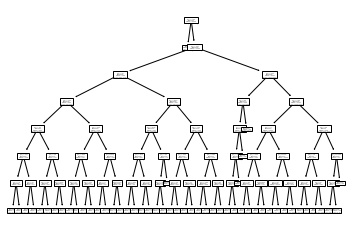

In [134]:
#############################################################
print("建立多层嵌套决策树模型")
#############################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler

###############################################################

def dtFitAndSave(x,y,saveName):
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt,yPredict

###############################################################
###简单模型3，resnet_like

def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]
    global_models = []
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    
    #build_model = keras.models.load_model(saveName)
    #build_model.fit([x],[yOneHot],epochs=10, batch_size=10000*1)
    build_model.fit(x,yOneHot,epochs=15000, batch_size=20000*1)#GPU用这个
    #saveName = "KerasSimple3_likeResnet.h5"
    build_model.save(saveName)
    #plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model

def getKerasResnetRVL(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
   

    ###  
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    
    
    return y
##########################################################################



##############################################################################################################################
#############################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
#############################################################
file1 = "./trainData/france_0_allSamples.csv"
print("reading data france")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
h,w = xyData.shape
x = xyData[:,1:23]#简单处理与SUMO数据库一致
x0rigin = xyData[:,1:w-1]#用所有的数据
y0rigin  = xyData[:,w-1]
x0rigin =x0rigin.astype(np.float32)#GPU 加这个
y0rigin =y0rigin.astype(np.int64)#GPU 加这个


ros = RandomOverSampler(random_state=0)
x0,y0= ros.fit_resample(x0rigin , y0rigin)

x0=x0.astype(np.float32)#GPU 加这个
y0=y0.astype(np.int64)#GPU 加这个
yl5 = y0
print("x0.shape:",x0.shape,"y0.shape:",y0.shape,"y0.type:", type(y0) )
del xyDataTmp #节省内存
del xyData #节省内存


##################################
print("原始样本分为3210和4两类")
index0 = np.where( (yl5 == 3)|(yl5 == 2) | (yl5 == 1) | (yl5 == 0))
index1 = np.where( (yl5 ==4))
x3210_4 = x0.copy()
y3210_4 = yl5.copy()
y3210_4[index0] = 3210

#计算下层标记210,3,4,
y5LabelFloor1 = yl5.copy()



##################################
print("3210样本分为210和3两类")
index0 = np.where( (yl5 == 2) | (yl5 == 1) | (yl5 == 0))
index1 = np.where( (yl5 ==3))

xTmp = x0[index0]
yTmp = yl5[index0]
yTmp[:] = 210

x = np.concatenate((xTmp,x0[index1]),axis=0)
y = np.concatenate((yTmp,yl5[index1]),axis=0)
x210_3 = x
y210_3 = y
print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )



##################################
print("210样本分为10和2两类")
index0 = np.where((yl5 == 1) | (yl5 == 0))
index1 = np.where( (yl5 ==2))
xTmp = x0[index0]
yTmp = yl5[index0]
yTmp[:] = 10

x = np.concatenate((xTmp,x0[index1]),axis=0)
y = np.concatenate((yTmp,yl5[index1]),axis=0)
x10_2 = x
y10_2 = y
print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
print(y10_2)


##################################
print("10样本分为0和1两类")
index0 = np.where( (yl5 == 0))
index1 = np.where( (yl5 ==1))
xTmp = x0[index0]
yTmp = yl5[index0]

x = np.concatenate((xTmp,x0[index1]),axis=0)
y = np.concatenate((yTmp,yl5[index1]),axis=0)

x1_0 = x
y1_0 = y
print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
print(y0_1)

##################################################
xFloors=  dict()
yFloors =  dict()
dtModeFloors=  dict()
dtPredictLabel = dict()
kerasPredictLabel = dict()
kerasModelNameFloors =dict()
encFloors= dict()
#################################################

if 0:
    print("5label 模型")
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 5 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
    if 0:
        kerasModel3_5label = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_5label=getKerasResnetRVL(x,enc,saveName)
    dt_5label,dt_PredictLabel = dtFitAndSave(x,yl5,"5label")
    enc_5label = enc
    
    xFloors[0] =  x.copy()
    yFloors[0] =  y.copy()
    dtModeFloors[0] =  dt_5label
    dtPredictLabel[0] = dt_PredictLabel.copy()
    kerasPredictLabel[0] = yKeras_5label.copy()
    kerasModelNameFloors[0] =saveName
    encFloors[0] = enc_5label

    
    
if 0:
    print("\n ####################Floor4 训练###############")
    x= x1_0
    y =y1_0
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 2 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_floor4.h5"
    print(saveName)
    if 0:
        kerasModel3_Floor4 = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_Floor4=getKerasResnetRVL(x,enc,saveName)
    dt_Floor4,dt_PredictLabel = dtFitAndSave(x,y,"Floor4")
    enc_floor4 = enc
    
    xFloors[4] =  x.copy()
    yFloors[4] =  y.copy()
    dtModeFloors[4] =  dt_Floor4
    dtPredictLabel[4] = dt_PredictLabel.copy()
    kerasPredictLabel[4] = yKeras_Floor4.copy()
    kerasModelNameFloors[4] =saveName
    encFloors[4] = enc_floor4
    
    
if 1:
    print("Floor3 训练")
    x= x10_2
    y =y10_2
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 2 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_floor3.h5"
    if 0:
        kerasModel3_Floor3 = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_Floor3=getKerasResnetRVL(x,enc,saveName)
    dt_Floor3,dt_PredictLabel = dtFitAndSave(x,y,"Floor3")
    enc_floor3 = enc
    
    xFloors[3] =  x.copy()
    yFloors[3] =  y.copy()
    dtModeFloors[3] =  dt_Floor3
    dtPredictLabel[3] = dt_PredictLabel.copy()
    kerasPredictLabel[3] = yKeras_Floor3.copy()
    kerasModelNameFloors[3] =saveName
    encFloors[3] = enc_floor3
    
if 1:
    print("####################################################################Floor2 训练")
    x= x210_3
    y =y210_3
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 2 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_floor2.h5"
    if 0:
        kerasModel3_Floor2 = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
        
    yKeras_Floor2=getKerasResnetRVL(x,enc,saveName)
    
    
    print('keras\n')
    mat1num = confusion_matrix(y, yKeras_Floor2)
    mat2acc = confusion_matrix(y, yKeras_Floor2,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
 
    
    dt_Floor2,dt_PredictLabel = dtFitAndSave(x,y,"Floor2")
    enc_floor2 = enc
    
    
    xFloors[2] =  x.copy()
    yFloors[2] =  y.copy()
    dtModeFloors[2] =  dt_Floor2
    dtPredictLabel[2] = dt_PredictLabel.copy()
    kerasPredictLabel[2] = yKeras_Floor2.copy()
    kerasModelNameFloors[2] =saveName
    encFloors[2] = enc_floor2
    
if 1:
    print("##########################################################Floor1 训练")
    x= x3210_4
    y =y3210_4
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) ,"y.unique",np.unique(y))
    
    num_labels = 2 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_floor1.h5"
    if 0:

        kerasModel3_Floor1 = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_Floor1=getKerasResnetRVL(x,enc,saveName)
    
    
    print('keras\n')
    mat1num = confusion_matrix(y, yKeras_Floor1)
    mat2acc = confusion_matrix(y, yKeras_Floor1,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
 

    dt_Floor1,dt_PredictLabel = dtFitAndSave(x,y,"Floor1")
    enc_floor1 = enc
    
    xFloors[1] =  x.copy()
    yFloors[1] =  y.copy()
    dtModeFloors[1] =  dt_Floor1
    dtPredictLabel[1] = dt_PredictLabel.copy()
    kerasPredictLabel[1] = yKeras_Floor1.copy()
    kerasModelNameFloors[1] =saveName
    encFloors[1] = enc_floor1



In [ ]:
!conda install -c conda-forge imbalanced-learn

In [142]:
#############################################################
print("论文比较图1")
#############################################################
def getKerasResnetLabel(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
 
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    
    
    return y


def hybridTest(x,y,dt,floorLabel,kerasLabel):
    nSamples,feturesNume  = x.shape
    yHyLabel  = np.zeros((nSamples,1))#混合模型预测标签
    dtLabel = np.zeros((nSamples,1))#决策树模型预测标签
    gini,yPredictProb= getDTSamplesInfo(x,dt)
    prdictMax = np.max(yPredictProb,axis=1)
    index1 = np.argmax(yPredictProb, axis = 1)
    index1 = index1.astype('int64')

    floorLabelTmp = np.array([floorLabel for i in range(nSamples) ])

    
    indexTmp1 = list(range(nSamples))
    
    dtLabel  = floorLabelTmp[indexTmp1,index1]
    yHyLabel = dtLabel.copy()
    
    
    
    tmp1 = np.where(gini>0.1)
    tmp2 = np.where(prdictMax<0.9)
    tmp3 = np.concatenate((tmp1[0],tmp2[0]),axis = 0)
    index2 = np.unique(tmp3)
 
    yHyLabel[index2] = kerasLabel[index2]
    switch2KerasIndex = index2
    hyCounter = nSamples-len(index2)                
                      
    


    print('混合识别中，决策树的数目和比例，hyCounter,%d,%.3f%%\n' %(hyCounter,hyCounter/nSamples*100))    
    
    tmp1 = classification_report(y,dtLabel)
    print('dt 准确率\n',tmp1)
    
    tmp1 = classification_report(y,yHyLabel)
    print('hybrid 准确率\n',tmp1)
    tmp1 = classification_report(y,kerasLabel)
    print('keras 准确率\n',tmp1)
    mat1num = confusion_matrix(y,yHyLabel)
    mat2acc = confusion_matrix(y,yHyLabel,normalize='pred')
    print('hybrid mat1num\n',mat1num)
    print('hybrid mat2acc\n',np.around(mat2acc , decimals=3))
    
    
    mat1num = confusion_matrix(y, kerasLabel)
    mat2acc = confusion_matrix(y, kerasLabel,normalize='pred')
    print('keras mat1num\n',mat1num)
    print('keras mat2acc\n',np.around(mat2acc , decimals=3))
    
    
    return dtLabel,yHyLabel,switch2KerasIndex

#############################################################
import warnings
warnings.filterwarnings('ignore')

print("多层嵌套准确率图1")

floorsLabel = [[43210],[4,3210],[3,210],[2,10],[0,1]];
                      
xFloorsTest = dict()
yFloorsTest = dict()
yOriginLabelFloorsTest = dict()

xFloorsTest[1] = x3210_4#每层原始数据x, 训练和对比用
yFloorsTest[1] = y3210_4#每层原始数据y，训练和对比用
yOriginLabelFloorsTest[1]= yl5#每层5label原始数据y，训练和对比用

dtPredictLabelTest = dict()
kerasPredictLabelTest = dict()
hybridPredictLabelTest = dict()                      
switch2KerasIndexTest = dict()

                      
for i in [1,2,3,4]:
    print("\n################分析第%d层########################" %i)
    x = xFloorsTest[i]
    y = yFloorsTest[i]
    print("y.unique",np.unique(y))
    

   
    if i == 1:
        dt = dt_Floor1
        saveName = "hybrid2_KerasSimple3_likeResnet_floor1.h5"
        kerasLabel = getKerasResnetLabel(x,enc_floor1,saveName)
    if i == 2:
        dt = dt_Floor2
        saveName = "hybrid2_KerasSimple3_likeResnet_floor2.h5"
        kerasLabel = getKerasResnetLabel(x,enc_floor2,saveName)
    if i == 3:
        dt = dt_Floor3
        saveName = "hybrid2_KerasSimple3_likeResnet_floor3.h5"
        kerasLabel = getKerasResnetLabel(x,enc_floor3,saveName)
    if i == 4:
        dt = dt_Floor4
        saveName = "hybrid2_KerasSimple3_likeResnet_floor4.h5"
        kerasLabel = getKerasResnetLabel(x,enc_floor4,saveName)
    
    
   
  
 
    floorLabel = floorsLabel[i]
    dtLabel,yHyLabel, switch2KerasIndex = hybridTest(x,y,dt,floorLabel,kerasLabel)
                      
    dtPredictLabelTest[i] = dtLabel
    kerasPredictLabelTest[i] =kerasLabel
    hybridPredictLabelTest[i] = yHyLabel               
    switch2KerasIndexTest[i] =switch2KerasIndex
    
    
    y5Label = yOriginLabelFloorsTest[i]#当前层x数据，对应的5label数据
    if i == 1:#将3210转为210,3
        indexTmp = np.where(yHyLabel == 3210)#上级预测为3210
        xFloorsTest[2] = x[indexTmp]#获得预测标签为3210的x数据
        
        tmpY= y5Label[indexTmp]#获得预测标签为3210的y数据（对应原始5label）
        yOriginLabelFloorsTest[2] = tmpY.copy()#获得预测标签为3210的y数据（对应原始5label），并保存起来给到下一层
        
        index0 = np.where( (tmpY == 2) | (tmpY == 1) | (tmpY== 0))#将其中标签为2，1，0的y数据转为标签210
        tmpY[index0] = 210
        yFloorsTest[2] = tmpY.copy()#将其中标签为2，1，0的y数据转为标签210,并给到下一层Floor
        

        
       
                      
    if i == 2:
        indexTmp = np.where(yHyLabel == 210)
        xFloorsTest[3] = x[indexTmp]#获得预测标签为210的x数据(注意x是上级预测为3210的数据)
        
        tmpY= y5Label[indexTmp]#获得预测标签为210的y数据（对应原始5label）
        yOriginLabelFloorsTest[3] = tmpY.copy()#获得预测标签为210的y数据（对应原始5label），并保存起来给到下一层
        
        index0 = np.where( (tmpY == 1) | (tmpY== 0))#将其中标签为1，0的y数据转为标签10
        tmpY[index0] = 10
        yFloorsTest[3] = tmpY.copy()#将其中标签为1，0的y数据转为标签10,并给到下一层Floor
      


    if i == 3:
        indexTmp = np.where(yHyLabel == 10)
        xFloorsTest[4] = x[indexTmp]#获得预测标签为10的x数据(注意x是上级预测为210的数据)
        
        tmpY= y5Label[indexTmp]#获得预测标签为10的y数据（对应原始5label）
        yOriginLabelFloorsTest[4] = tmpY.copy()#获得预测标签为210的y数据（对应原始5label），并保存起来给到下一层
        
        
        index0 = np.where(tmpY == 1)#将其中标签为1，0的y数据转为标签10
        tmpY[index0] = 1
        
        index0 = np.where(tmpY == 0)#将其中标签为1，0的y数据转为标签10
        tmpY[index0] = 0
        
        yFloorsTest[4] = tmpY.copy()#将其中标签为1，0的y数据转为标签10,并给到下一层Floor
     
 
    

                      
        
                      


论文比较图1
多层嵌套准确率图1

################分析第1层########################
y.unique [   4 3210]
混合识别中，决策树的数目和比例，hyCounter,278532,44.698%

dt 准确率
               precision    recall  f1-score   support

           4       0.73      0.18      0.28    124628
        3210       0.83      0.98      0.90    498512

    accuracy                           0.82    623140
   macro avg       0.78      0.58      0.59    623140
weighted avg       0.81      0.82      0.78    623140

hybrid 准确率
               precision    recall  f1-score   support

           4       1.00      0.99      0.99    124628
        3210       1.00      1.00      1.00    498512

    accuracy                           1.00    623140
   macro avg       1.00      0.99      1.00    623140
weighted avg       1.00      1.00      1.00    623140

keras 准确率
               precision    recall  f1-score   support

           4       1.00      1.00      1.00    124628
        3210       1.00      1.00      1.00    498512

    accuracy            

In [9]:
！nvidia-smi

SyntaxError: invalid character in identifier (1196287352.py, line 1)

In [55]:
a = np.array([8,8,0,0,4,5,6,8,1,2,3])
b =[1,1,1,1,1]
c = a[b]
print(c)

[8 8 8 8 8]
